<a href="https://colab.research.google.com/github/arminmu13106-art/exam-0-arminmu13106-art/blob/Assignment_3-20251202/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science*
# Programming Assignment 3 - Predicting Video Game Sales with Deep Learning

In this programming assignment, you need to apply your new deep learning knowledge. In contrast to PA2, you don't have to bother about feature engineering. You will build an artificial neural network with multiple layers that learns features from the raw data.

## Introduction and Dataset

You are provided with a dataset containing a list of video games with sales greater than 100.000 copies. Again, your task is to build a model predicting the yearly global sales (column ``Global_Sales``) of a video game leveraging the available features.

To help you get started, the following blocks of code import the dataset using pandas:

In [1]:
import pandas as pd

In [2]:
data_path = 'https://raw.githubusercontent.com/GuntherGust/tds2_data/main/data/video_game_sales.csv'
df = pd.read_csv(data_path)
df.head()

,Name,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,82.53,76.0,51.0,8.0,322.0,E
1,Super Mario Bros.,NES,1985.0,Platform,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,32.77,80.0,73.0,8.0,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,NaN,NaN,NaN,NaN,NaN


## Creating Dataloaders

First, import everything we need for the tabular model

In [3]:
!pip install -Uqq fastai  # upgrade fastai on colab
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split

To create [TabularDataLoaders](https://docs.fast.ai/tabular.data.html#TabularDataLoaders), you need to assign the variables to dependent, categorical and continuous variables

In [4]:
# check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16711 entries, 0 to 16710
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16709 non-null  object 
 1   Platform         16711 non-null  object 
 2   Year_of_Release  16442 non-null  float64
 3   Genre            16709 non-null  object 
 4   Global_Sales     16711 non-null  float64
 5   Critic_Score     8130 non-null   float64
 6   Critic_Count     8130 non-null   float64
 7   User_Score       10007 non-null  float64
 8   User_Count       7585 non-null   float64
 9   Rating           9942 non-null   object 
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


In [5]:
print("=== NaN ===")
print(df.isnull().sum())

=== NaN ===
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Global_Sales          0
Critic_Score       8581
Critic_Count       8581
User_Score         6704
User_Count         9126
Rating             6769
dtype: int64


In [6]:
# Handling Missing Values
from sklearn.impute import SimpleImputer
import numpy as np

def basic_data_cleaning(df):
    df_clean = df.copy()
    if df_clean['Global_Sales'].isna().any():
        df_clean['Global_Sales'] = df_clean['Global_Sales'].fillna(0)

    df_clean['Global_Sales_log'] = np.log1p(df_clean['Global_Sales'])

    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if df_clean[col].isna().sum() < 10:
            df_clean[col] = df_clean[col].fillna('Unknown')

    return df_clean

game_sales_data_clean = basic_data_cleaning(df)

In [7]:
from fastai.tabular.all import *

def prepare_fastai_dataloaders(game_sales_data_clean):

    numeric_cols = game_sales_data_clean.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = game_sales_data_clean.select_dtypes(include=['object']).columns.tolist()

    target_var = 'Global_Sales_log'
    if target_var in numeric_cols:
        numeric_cols.remove(target_var)
    if 'Global_Sales' in numeric_cols:
        numeric_cols.remove('Global_Sales')


    dls = TabularDataLoaders.from_df(
        game_sales_data_clean,
        y_names = target_var,
        cat_names=categorical_cols,
        cont_names=numeric_cols,
        procs=[Categorify, FillMissing, Normalize],
        splits=RandomSplitter(valid_pct=0.2, seed=42),
        bs=16,                ### Set the batch size to 16
        y_block=RegressionBlock()
    )

    return dls, categorical_cols, numeric_cols

In [8]:
dls, cat_cols, cont_cols = prepare_fastai_dataloaders(game_sales_data_clean)

print(f"DataLoaders: {type(dls)}")

DataLoaders: <class 'fastai.tabular.data.TabularDataLoaders'>


/usr/local/lib/python3.12/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.12/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

fast.ai contains classes that define [transformations](https://docs.fast.ai/tutorial.tabular.html) for preprocessing. Provide a list of appropriate preprocessing steps.

In [9]:
# Write your code here
game_sales_data_clean.head()

,Name,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Global_Sales_log
0,Wii Sports,Wii,2006.0,Sports,82.53,76.0,51.0,8.0,322.0,E,4.425206
1,Super Mario Bros.,NES,1985.0,Platform,40.24,NaN,NaN,NaN,NaN,NaN,3.719409
2,Mario Kart Wii,Wii,2008.0,Racing,35.52,82.0,73.0,8.3,709.0,E,3.597860
3,Wii Sports Resort,Wii,2009.0,Sports,32.77,80.0,73.0,8.0,192.0,E,3.519573
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,NaN,NaN,NaN,NaN,NaN,3.477232


You also need to define the train and validation set (using indices!).
- Use a train/test split of 80/20

In [10]:
# Write your code here
print("dls:")

print(f"train: {len(dls.train_ds)}")
print(f"valid: {len(dls.valid_ds)}")
print(f"{len(dls.train_ds)}:{len(dls.valid_ds)} = "
      f"{len(dls.train_ds)/(len(dls.train_ds)+len(dls.valid_ds)):.0%}:"
      f"{len(dls.valid_ds)/(len(dls.train_ds)+len(dls.valid_ds)):.0%}")

dls:
train: 13369
valid: 3342
13369:3342 = 80%:20%


In [11]:
print(game_sales_data_clean.columns)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Global_Sales',
       'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating',
       'Global_Sales_log'],
      dtype='object')


Now you're ready to create the [TabularDataLoaders](https://docs.fast.ai/tabular.data.html#TabularDataLoaders) that you'll use for training.
- Use the Factory Method that creates the `dls` from a dataframe
- Set the batch size to 16

In [12]:
# Write your code here
dls.show_batch()

,Name,Platform,Genre,Rating,Year_of_Release_na,Critic_Score_na,Critic_Count_na,User_Score_na,User_Count_na,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Global_Sales_log
0,"Warhammer 40,000: Dawn of War II - Retribution",PC,Strategy,M,False,False,False,False,False,2011.0,80.0,51.999999,7.80,234.999994,0.076961
1,Battle of Giants: Mutant Insects,DS,Strategy,E10+,False,True,True,False,True,2010.0,71.0,22.000000,7.13,25.000000,0.231112
2,Spirit Camera: The Cursed Memoir,3DS,Adventure,T,False,False,False,False,False,2012.0,54.0,35.000000,6.10,27.999998,0.198851
3,James Bond 007: Blood Stone,PS3,Shooter,T,False,False,False,False,False,2010.0,65.0,49.000000,7.40,45.000000,0.530628
4,Rugrats in Paris: The Movie,PS,Action,#na#,False,True,True,True,True,2000.0,71.0,22.000000,7.13,25.000000,1.508512
5,Go Diego Go! Great Dinosaur Rescue,Wii,Action,#na#,False,True,True,True,True,2008.0,71.0,22.000000,7.13,25.000000,0.457425
6,Just Dance 4,PS3,Misc,E10+,False,False,False,False,False,2012.0,77.0,5.000000,7.10,28.999997,0.357674
7,Tomb Raider: Underworld,DS,Action,T,False,False,False,False,False,2008.0,70.0,9.000000,8.40,9.999999,0.173953
8,Rumble Racing,PS2,Racing,E,False,False,False,False,False,2001.0,85.0,17.000000,8.20,9.000000,0.190620
9,We Love Katamari,PS2,Puzzle,E,False,False,False,False,False,2005.0,86.0,60.999997,8.90,50.999999,0.418710


How many features numerical and categorical feautures are created by the dataloaders after preprocessing the data?
- print the names and the count of these features

In [13]:
# Write your code here
for i, name in enumerate(dls.cat_names, 1):
    print(f"  {i}. {name}")
print(f"{len(dls.cat_names)} categorical feautures\n")

for i, name in enumerate(dls.cont_names, 1):
    print(f"  {i}. {name}")
print(f"{len(dls.cont_names)} numerical feautures\n")

print(f"ALL features: {len(dls.cat_names) + len(dls.cont_names)}")

  1. Name
  2. Platform
  3. Genre
  4. Rating
  5. Year_of_Release_na
  6. Critic_Score_na
  7. Critic_Count_na
  8. User_Score_na
  9. User_Count_na
9 categorical feautures

  1. Year_of_Release
  2. Critic_Score
  3. Critic_Count
  4. User_Score
  5. User_Count
5 numerical feautures

ALL features: 14


## Modeling

### Create Learner

Create an [appropriate learner](https://docs.fast.ai/tabular.learner.html) for data. A learner creates a neural network for us.
- Use 100 nodes in the first and 50 nodes in the second layer
- Choose the [metrics](https://docs.fast.ai/metrics.html) *root mean squared error* and mean *absolute error*. You can pass a list of metrics to the learner.
- Bonus: Looking at the keyword arguments of the [tabular learner](https://docs.fast.ai/tabular.learner.html), how could you limit the predicted sales appropriately?

In [14]:
# Write your code here
from fastai.tabular.all import *
learn = tabular_learner(
    dls,
    layers=[100, 50],
    metrics=[rmse, mae],
    n_out=1,
    y_range=(0, None)
)

How many Embeddings are there in the model? Use `learn.dls.show_batch()` to explain why!

In [15]:
# Write your answer here
print(learn.model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(11558, 302)
    (1): Embedding(32, 11)
    (2): Embedding(14, 7)
    (3): Embedding(9, 5)
    (4-8): 5 x Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=345, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=0, high=None)
  )
)


In [21]:
learn.dls.show_batch()

,Name,Platform,Genre,Rating,Year_of_Release_na,Critic_Score_na,Critic_Count_na,User_Score_na,User_Count_na,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Global_Sales_log
0,Cabela's Big Game Hunter 2012,PS3,Sports,T,False,True,True,False,True,2011.0,71.000000,22.000000,7.13,25.000000,0.207014
1,Daisy Fuentes Pilates,Wii,Sports,E,False,True,True,False,True,2009.0,71.000000,22.000000,7.13,25.000000,0.223144
2,Family Game Night 4: The Game Show,PS3,Misc,E,False,True,True,False,True,2011.0,71.000000,22.000000,7.13,25.000000,0.104360
3,Top Spin,XB,Sports,E,False,False,False,False,False,2003.0,89.000000,43.999999,8.20,31.000002,0.378436
4,KORG DS-10 Synthesizer,DS,Misc,E,False,False,False,False,False,2008.0,82.000000,11.000000,8.20,13.000003,0.198851
5,"Ni Hao, Kai-lan: New Year's Celebration",DS,Misc,EC,False,True,True,False,True,2009.0,71.000000,22.000000,7.13,25.000000,0.182322
6,SSX 3,PS2,Sports,E,False,False,False,False,False,2003.0,92.999999,40.999999,9.10,125.000001,0.982078
7,Tokyo Jungle,PS3,Action,T,False,False,False,False,False,2012.0,74.000000,59.999998,8.40,89.000000,0.231112
8,Shanghai: True Valor,PS,Puzzle,#na#,False,True,True,True,True,1998.0,71.000000,22.000000,7.13,25.000000,0.019803
9,Surf's Up,DS,Sports,E,False,False,False,False,False,2007.0,56.000000,5.000000,7.00,3.999998,0.246860


In [22]:
print(f"\n{dls.cat_names}")
print(f"\n Embeddings:{len(dls.cat_names)}")


['Name', 'Platform', 'Genre', 'Rating', 'Year_of_Release_na', 'Critic_Score_na', 'Critic_Count_na', 'User_Score_na', 'User_Count_na']

 Embeddings:9


### Find the learning rate
You need to find a suitable learning rate for the training
- Read the [docs](https://fastai1.fast.ai/callbacks.one_cycle.html) how to find the right learning rate
- Repeat this step until you get a meaningful plot ;)

In [44]:
learn = tabular_learner(
    dls,
    layers=[100, 50],
    metrics=[rmse, mae],
    n_out=1,
)

SuggestedLRs(valley=0.004365158267319202)

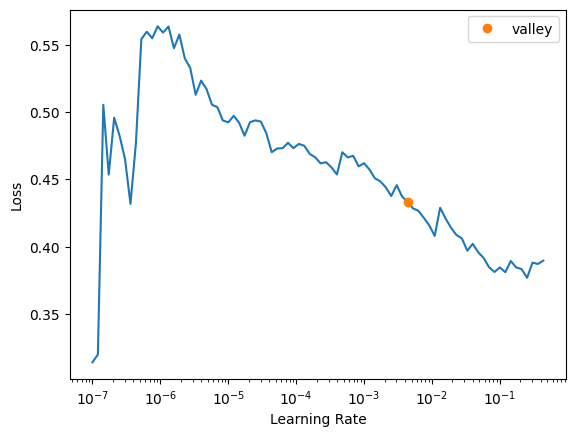

In [45]:
learn.lr_find()

### Fit the model

- How many epochs (cycles) are necessary to train the model? Is there a problem with overfitting?

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.116273,0.113669,0.337149,0.207403,00:08
1,0.088645,0.097845,0.312802,0.198623,00:08
2,0.057634,0.090885,0.301471,0.185613,00:09
3,0.046509,0.085804,0.292924,0.191391,00:08
4,0.035200,0.084865,0.291316,0.186646,00:08


Better model found at epoch 0 with valid_loss value: 0.11366915702819824.
Better model found at epoch 1 with valid_loss value: 0.0978449136018753.
Better model found at epoch 2 with valid_loss value: 0.09088478982448578.
Better model found at epoch 3 with valid_loss value: 0.08580436557531357.
Better model found at epoch 4 with valid_loss value: 0.08486500382423401.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

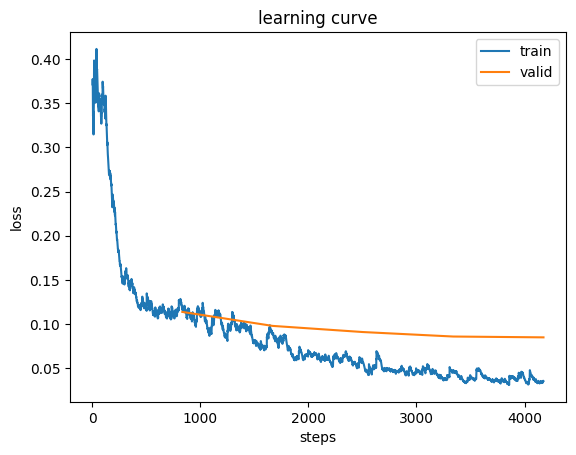

In [46]:
# Write your answer and code here
valley_lr = 0.004365158267319202 # everytime different! YOU NEED TO FILL IT HERE

save_callback = SaveModelCallback(
    monitor='valid_loss',
    fname='best_model',
    with_opt=True,
    reset_on_fit=False
)


learn.fit_one_cycle(
    n_epoch=5,
    lr_max=valley_lr,
    wd=0.01,
    cbs=save_callback
)

learn.recorder.plot_loss()

### Evaluate the model

Report the in-sample as well as the out-of-sample performance usinge the mean absolute error.

In [47]:
# Write your code here

train_preds, train_targets = learn.get_preds(dl=dls.train)
valid_preds, valid_targets = learn.get_preds(dl=dls.valid)

train_preds_np = train_preds.numpy().flatten()
train_targets_np = train_targets.numpy().flatten()
valid_preds_np = valid_preds.numpy().flatten()
valid_targets_np = valid_targets.numpy().flatten()

train_preds_orig = np.expm1(train_preds_np)
train_targets_orig = np.expm1(train_targets_np)
valid_preds_orig = np.expm1(valid_preds_np)
valid_targets_orig = np.expm1(valid_targets_np)

from sklearn.metrics import mean_absolute_error

train_mae_log = mean_absolute_error(train_targets_np, train_preds_np)
valid_mae_log = mean_absolute_error(valid_targets_np, valid_preds_np)

train_mae_orig = mean_absolute_error(train_targets_orig, train_preds_orig)
valid_mae_orig = mean_absolute_error(valid_targets_orig, valid_preds_orig)

print(f"\n train (In-sample):")
print(f"  MAE (log): {train_mae_log:.6f}")
print(f"  MAE (original): {train_mae_orig:.4f} ")

print(f"\n valid(Out-of-sample):")
print(f"  MAE (log): {valid_mae_log:.6f}")
print(f"  MAE (original): {valid_mae_orig:.4f} ")

print(f" {valid_mae_log/train_mae_log:.4f}")


 train (In-sample):
  MAE (log): 0.103940
  MAE (original): 0.2510 

 valid(Out-of-sample):
  MAE (log): 0.186646
  MAE (original): 0.3664 
 1.7957


## Discussion

Looking at the results, discuss the advantages and disadvantages of deep learning for tabular data.

In [48]:
# Write your answer here
# To solve the same problem using Random forest and Deeplearning,
###  Random forest:
#   require specific data engineering and cleaning
#   you can fill the NaN with average or most often occured number
#   you can explain which parameter is important
###  Deeplearning:
#   you need GPU!
#   ...and more data
#   don't need so many data engineering and cleaning, but NaN value still need to be replaced
#   and it's slow